# 1. Load the json dataset from google drive

In [ ]:
import json
from google.colab import drive
drive.mount('/content/drive')

with open("/content/drive/MyDrive/doc.json", "r") as f:
    articles = json.load(f)

Mounted at /content/drive


In [ ]:
print(articles)

[{'abstract': 'The first hints that the phones of nutrition policy makers were infected were strange messages from unknown contacts.', 'web_url': 'https://www.nytimes.com/2017/02/11/technology/hack-mexico-soda-tax-advocates.html', 'headline': {'main': 'Spyware’s Odd Targets: Backers of Mexico’s Soda Tax'}, 'pub_date': '2017-02-11T17:50:15+0000', 'news_desk': 'Business', 'text': 'By Nicole Perlroth\nSAN FRANCISCO — Last summer, Dr. Simón Barquera’s phone started buzzing with a series of disturbing text messages from unknown numbers. One said his daughter had been in a serious accident. Another claimed to be from a friend whose father had died — with a link to funeral details.\nYet another message informed Dr. Barquera, the director of nutrition policy at Mexico’s National Institute of Public Health, that a Mexican news outlet had accused him of negligence, again with a link. And in more menacing messages, someone claimed to be sleeping with Dr. Barquera’s wife. That included a link to w

# 2. Use GPT-5 mini to extract entities from dataset and output a json file

In [ ]:
import json
from openai import OpenAI

# Initialize the client
client = OpenAI(api_key="YOUR_API_KEY_HERE")

# Function to extract entities
def extract_entities(article):
    prompt = f"""You are a data extraction assistant. First, you know how to extract metadate of news articles, such as headline, abstract, web_url, publication date, and news desk of articles.
Second, you can read articles and recognize the people mentioned in them, understand their roles when provided, and identify direct quotes attributed to them, including the time, location, and context in which those quotes were made.
Now, extract the following structured data from the provided content. Return as JSON with these fields:

1. article_metadata:
    - headline
    - abstract
    - web_url
    - pub_date
    - news_desk

2. people: a list of people mentioned in the article, each with:
    - name
    - role (title/position if given)
    - direct_quote (exact quote spoken by them)
    - where (location, event, or publication where they said it)
    - when (time/date if stated)
    - context (why they said it or circumstances around it)

Include ONLY people who have a direct quote.

Article:
{json.dumps(article, ensure_ascii=False)}
"""
    response = client.chat.completions.create(
        model="gpt-5-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )
    # Parse the LLM output
    output_text = response.choices[0].message.content
    try:
        return json.loads(output_text)
    except json.JSONDecodeError:
        # Return raw text if JSON parse fails
        return {"raw_output": output_text}

# Process all articles
extracted_data = [extract_entities(article) for article in articles]

# Save to a new JSON file
with open("extracted_entities.json", "w", encoding="utf-8") as f:
    json.dump(extracted_data, f, ensure_ascii=False, indent=2)


In [2]:
!pip install neo4j

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.8/325.8 kB 7.1 MB/s eta 0:00:00


# 3. Create the graph using the output from GPT5-mini

Each article is a node with headline, pub_date, web_url, abstract,and news_desk.

Each person is a node with name, role.

Each quote is a node with text, where, when, and the context.

QUOTED_IN connects person → article.

APPEARED_IN connects quote → article.

MADE_QUOTE connects person → quote

CO_OCCURS_IN {article:$headline} connects person → person


In [7]:
from neo4j import GraphDatabase
import json

# Neo4j info
NEO4J_URI = "neo4j+s://802c91da.databases.neo4j.io"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "YahiH6MGX08bkDFuagbIBnbeIVfmxAY1vSbBodHpG9s"

# JSON output from gpt-5 mini
data = {
  "article_metadata": {
    "headline": "Spyware’s Odd Targets: Backers of Mexico’s Soda Tax",
    "abstract": "The first hints that the phones of nutrition policy makers were infected were strange messages from unknown contacts.",
    "web_url": "https://www.nytimes.com/2017/02/11/technology/hack-mexico-soda-tax-advocates.html",
    "pub_date": "2017-02-11T17:50:15+0000",
    "news_desk": "Business"
  },
  "people": [
    {
      "name": "Luis Fernando García",
      "role": "Director of Red en Defensa de los Derechos Digitales (R3D), a Mexican digital rights nonprofit",
      "direct_quote": "This is proof that surveillance in Mexico is out of control. When we have proof that this surveillance is being used against nutritional activists, it’s clear Mexico should not be given these technologies.",
      "where": "Statement to The New York Times",
      "when": "Last summer",
      "context": "Reacting to confirmation that spyware was used against Mexican nutrition policy makers and activists."
    },
    {
      "name": "Lorena Cerdán",
      "role": "Director of ConMéxico (industry group representing Coca-Cola and PepsiCo)",
      "direct_quote": "This is the first we’re hearing of it. And frankly, it scares us, too.",
      "where": "Statement to The New York Times",
      "when": "Not specified",
      "context": "Responding to allegations that ConMéxico or its members might have been involved in hacking the phones of soda tax advocates."
    },
    {
      "name": "Ricardo Alday",
      "role": "Spokesman for the Mexican Embassy in Washington",
      "direct_quote": "Mexico’s intelligence systems are subject to federal relevant legislation and have legal authorization. They are not used against journalists or activists. All contracts with the federal government are done in accordance with the law.",
      "where": "Statement to The New York Times",
      "when":"Thursday",
      "context": "Defending the Mexican government’s use of surveillance technology after questions arose about hacking of nutrition policy makers’ phones."
    },
    {
      "name": "John Scott-Railton",
      "role": "Senior researcher at Citizen Lab",
      "direct_quote": "This is one of the most brazen cases of abuse we have ever seen. It points to a total breakdown of government oversight in Mexico, and a complete failure of due diligence by the NSO Group.",
      "where": "Statement to The New York Times",
      "when": "Not specified",
      "context": "Condemning the use of NSO spyware against health researchers and activists in Mexico."
    },
    {
      "name": "Dr. Simón Barquera",
      "role": "Director of nutrition policy at Mexico’s National Institute of Public Health",
      "direct_quote": "Suddenly, you are aware of everything you say. Everything you say feels like a potential threat, that it could come back to haunt you.",
      "where": "Interview with The New York Times",
      "when": "August",
      "context": "Discussing the personal impact of discovering spyware on his phone and its effect on his communications."
    }
  ]
}
# ---------- NEO4J CONNECTION ----------
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

def create_graph(tx, article, people):
    # Create the article, person and quote node
    tx.run("""
        MERGE (a:Article {
            headline: $headline,
            web_url: $web_url
        })
        SET a.abstract = $abstract,
            a.pub_date = $pub_date,
            a.news_desk = $news_desk
    """, **article)

      # Keep track of all person names for co-occurrence links
    person_names = []

    for person in people:
        tx.run("""
            MERGE (p:Person {name: $name})
            SET p.role = $role
        """, name=person["name"], role=person["role"])

        tx.run("""
            MERGE (q:Quote {
                text: $text,
                where: $where,
                when: $when,
                context: $context
            })
        """, text=person["direct_quote"], where=person["where"], when=person["when"], context=person["context"])

        # Link relationships
        tx.run("""
            MATCH (p:Person {name: $name}),
                  (a:Article {headline: $headline, web_url: $web_url}),
                  (q:Quote {text: $text})
            MERGE (p)-[:MADE_QUOTE]->(q)
            MERGE (q)-[:APPEARED_IN]->(a)
            MERGE (p)-[:QUOTED_IN]->(a)
        """, name=person["name"], headline=article["headline"], web_url=article["web_url"], text=person["direct_quote"])

        person_names.append(person["name"])

    # Create co-occurrence links between all people in this article
    for i in range(len(person_names)):
        for j in range(i+1, len(person_names)):
            tx.run("""
                MATCH (p1:Person {name: $name1}), (p2:Person {name: $name2}),
                      (a:Article {headline: $headline, web_url: $web_url})
                MERGE (p1)-[:CO_OCCURS_IN {article:$headline}]->(p2)
                MERGE (p2)-[:CO_OCCURS_IN {article:$headline}]->(p1)
            """, name1=person_names[i], name2=person_names[j],
                 headline=article["headline"], web_url=article["web_url"])

# Run the transaction
with driver.session(database="neo4j") as session:
    session.execute_write(create_graph, data["article_metadata"], data["people"])

print("Graph created successfully in Neo4j!")

driver.close()


Graph created successfully in Neo4j!


# 5. Use the query in Neo4j to see the whole graph:

MATCH (a:Article {web_url: "https://www.nytimes.com/2017/02/11/technology/hack-mexico-soda-tax-advocates.html"})

MATCH (p:Person)-[r1:MADE_QUOTE]->(q:Quote)-[r2:APPEARED_IN]->(a)

MATCH (p)-[r3:QUOTED_IN]->(a)

MATCH (p)-[r4:CO_OCCURS_IN]-(other:Person)

RETURN p, q, a, r1, r2, r3, r4, other


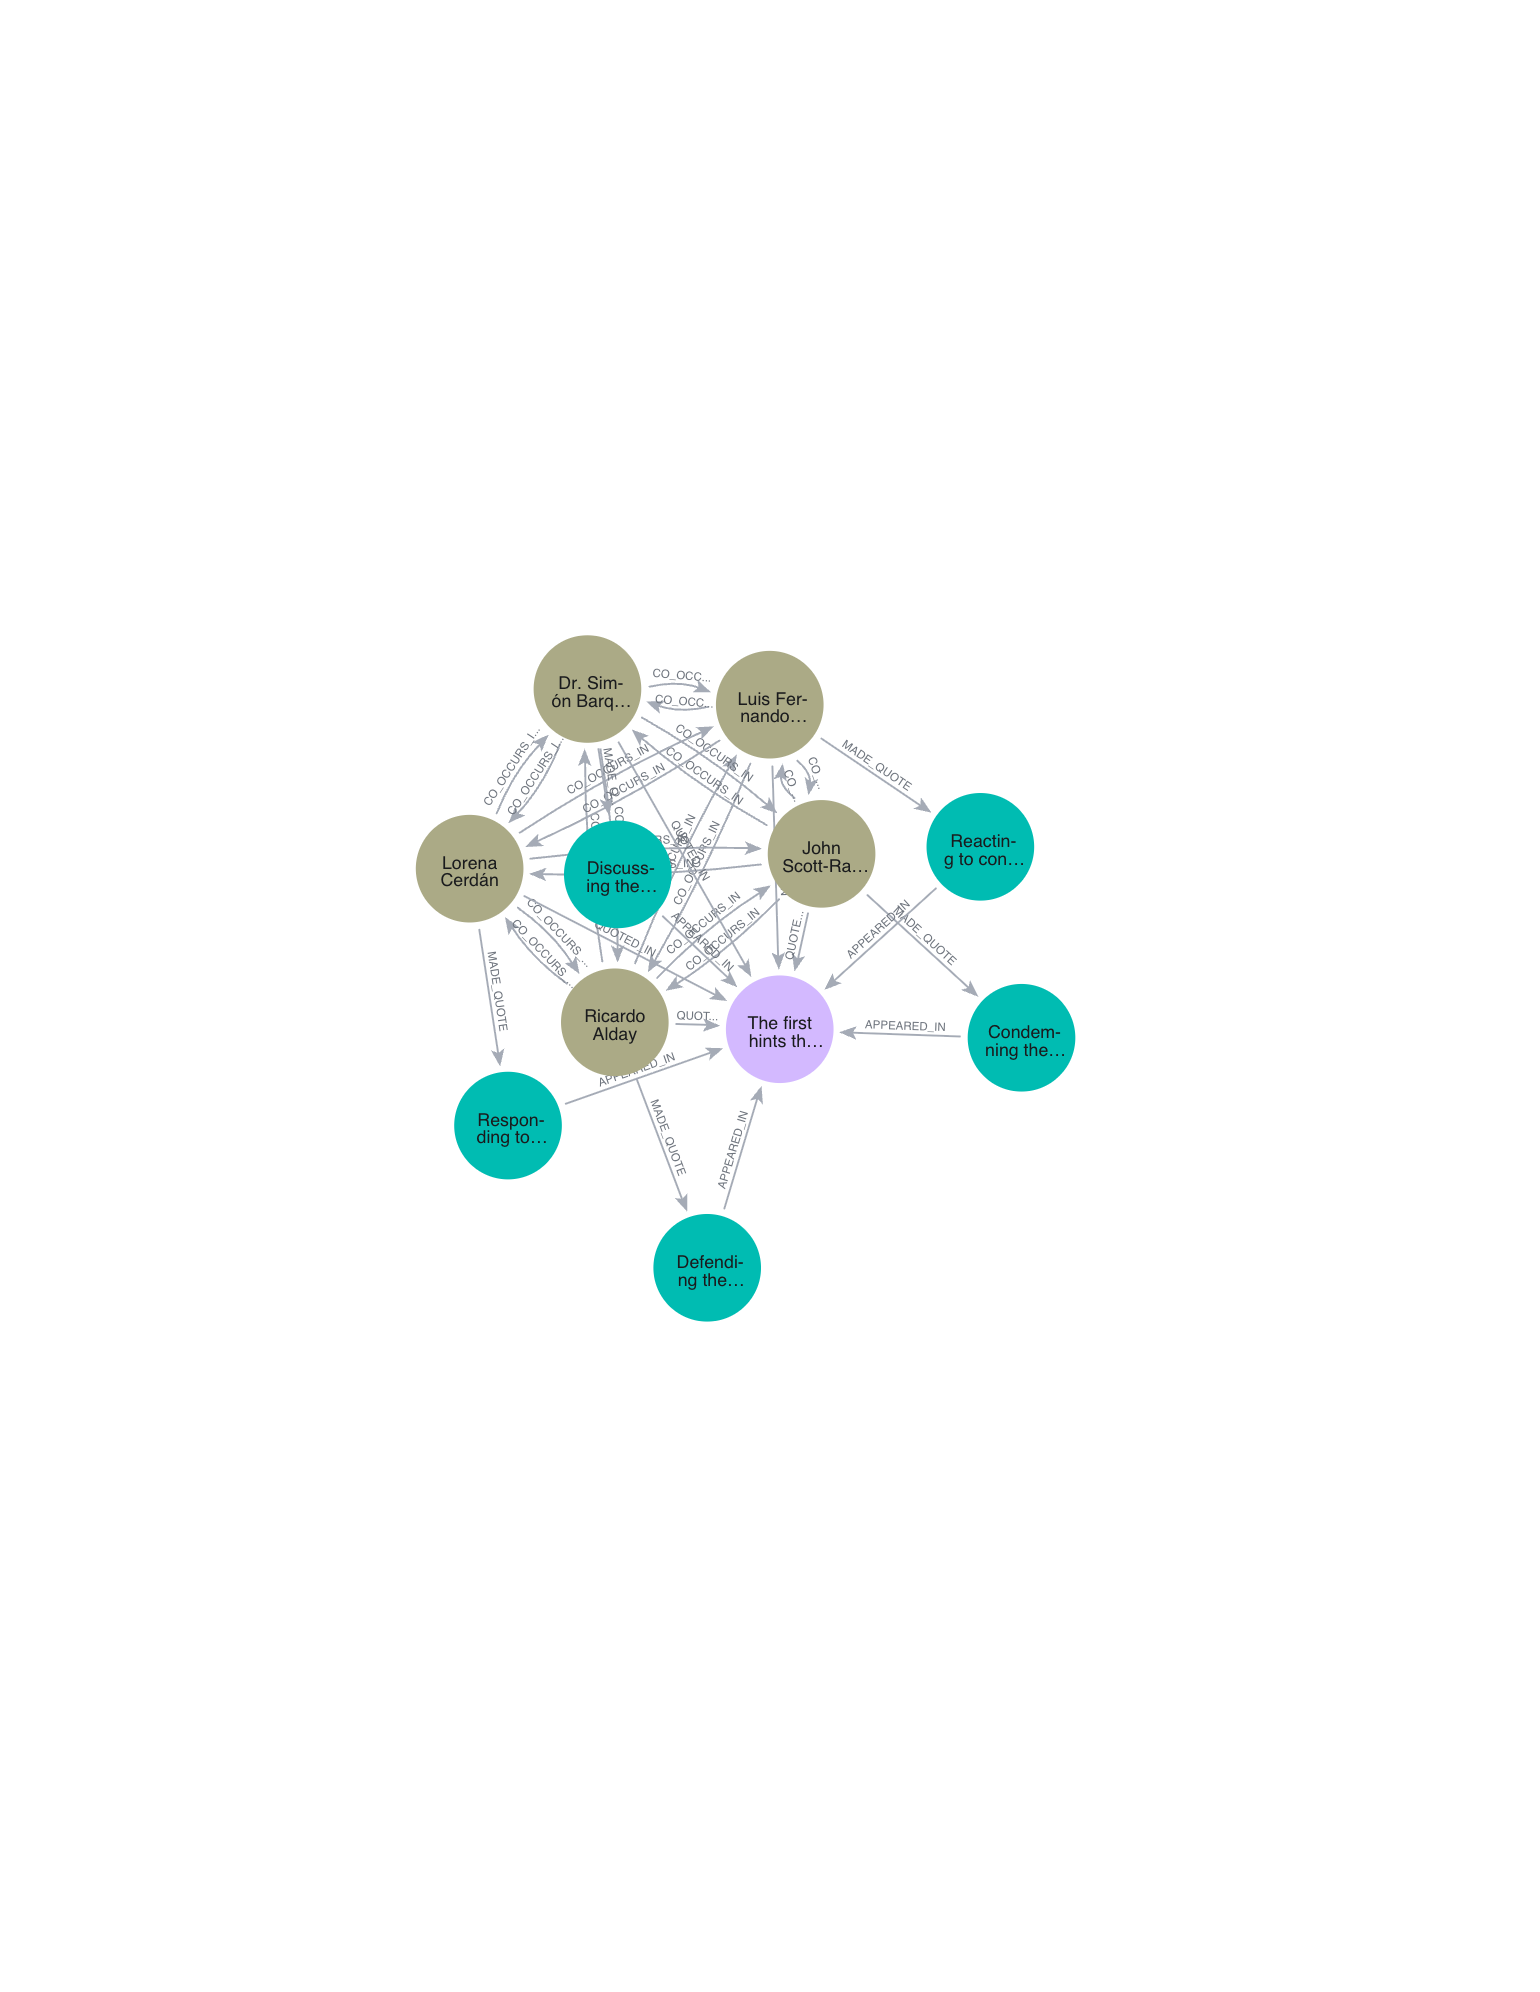